<div style="height:100px;">
    <img src="https://www.awi.de/typo3conf/ext/sms_boilerplate/Resources/Public/Images/AWI/awi_logo.svg" width=200 height=50 style="position:absolute;right:20px;">
</div>


In [1]:
import numpy as np
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable 

import cartopy, cartopy.crs as ccrs
import cartopy.feature as cfeature, cartopy.mpl.ticker as cticker

import warnings
warnings.simplefilter("ignore")

In [2]:
var = 'thetao'
str_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [3]:
def add_symbols(ax) -> None:
    for lat, lon, symbol in zip(
        [lat_cs, lat_bs1, lat_bs2],
        [lon_cs, lon_bs1, lon_bs2],
        ['CS', 'BS1', 'BS2']
    ):
        xlat = lat.stop - (lat.stop - lat.start) / 2
        xlon = lon.stop - (lon.stop - lon.start) / 2
        ax.annotate(
            symbol, xy=(xlon,xlat), fontsize=16, zorder=10, color='white',
            bbox=dict(boxstyle='round', alpha=.5, fc="gray", ec='black', lw=.2)
        )

In [4]:
depth = slice(0,581)
time = slice('1958', '2007')
time_1 = slice('2080', '2100')
time_2 = slice('2180', '2200')     

# region - North Atlantic
lat_na = slice(-30,90)
lon_na = slice(-30,80)

# region = 'CelticSea' (Celtic Sea + English Channel)   
lat_cs = slice(47, 52)
lon_cs = slice(-12, -1)

# region = 'Barents Sea whole'
lat_bs = slice(68, 72)
lon_bs = slice(10, 40) 

# region = 'Barents Sea' (area 1)
lat_bs1 = slice(68, 72)
lon_bs1 = slice(30, 40)

# region = 'Barents Sea' (area 2)
lat_bs2 = slice(68, 72)
lon_bs2 = slice(10, 30)

In [5]:
soda = xr.open_mfdataset('../soda/*temp_SODA_masked_north-atlantic.nc')
soda_1958_2007_na = soda.sel(
    time=time, latitude=lat_na, longitude=lon_na, depth_coord=depth
)[var]
soda_1958_2007_cs = soda.sel(
    time=time, latitude=lat_cs, longitude=lon_cs, depth_coord=depth
)[var]
soda_1958_2007_bs1 = soda.sel(
    time=time, latitude=lat_bs1, longitude=lon_bs1, depth_coord=depth
)[var]
soda_1958_2007_bs2 = soda.sel(
    time=time, latitude=lat_bs2, longitude=lon_bs2, depth_coord=depth
)[var]

___
Fig. 1. Spatial map SODA + seasonal plots SODA (4 subplots)
Vertically averaged over depths 0-580m, annual mean over 1958-2007 (the whole SODA period that I used in growth model simulations).

Seasonal plots: median and IQR (quantiles 0.25 and 0.75) over space and depth 
regions: Celtic Sea, Barents Sea (area 1), Barents Sea (area 2)

In [6]:
ds_fig1_spatial_map = soda_1958_2007_na.mean('depth_coord').groupby('time.year').mean('time').mean('year').load()

# Seasonal plots: median and IQR (quantiles 0.25 and 0.75) over space and depth 
ds_fig1_cs_median = soda_1958_2007_cs.median(['depth_coord', 'longitude', 'latitude']).groupby('time.month').mean().load()
ds_fig1_bs1_median = soda_1958_2007_bs1.median(['depth_coord', 'longitude', 'latitude']).groupby('time.month').mean().load()
ds_fig1_bs2_median = soda_1958_2007_bs2.median(['depth_coord', 'longitude', 'latitude']).groupby('time.month').mean().load()

ds_fig1_cs_q25 = soda_1958_2007_cs.quantile(.25, ['depth_coord', 'latitude', 'longitude']).groupby('time.month').mean().load()
ds_fig1_bs1_q25 = soda_1958_2007_bs1.quantile(.25, ['depth_coord', 'latitude', 'longitude']).groupby('time.month').mean().load()
ds_fig1_bs2_q25 = soda_1958_2007_bs2.quantile(.25, ['depth_coord', 'latitude', 'longitude']).groupby('time.month').mean().load()

ds_fig1_cs_q75 = soda_1958_2007_cs.quantile(.75, ['depth_coord', 'latitude', 'longitude']).groupby('time.month').mean().load()
ds_fig1_bs1_q75 = soda_1958_2007_bs1.quantile(.75, ['depth_coord', 'latitude', 'longitude']).groupby('time.month').mean().load()
ds_fig1_bs2_q75 = soda_1958_2007_bs2.quantile(.75, ['depth_coord', 'latitude', 'longitude']).groupby('time.month').mean().load()

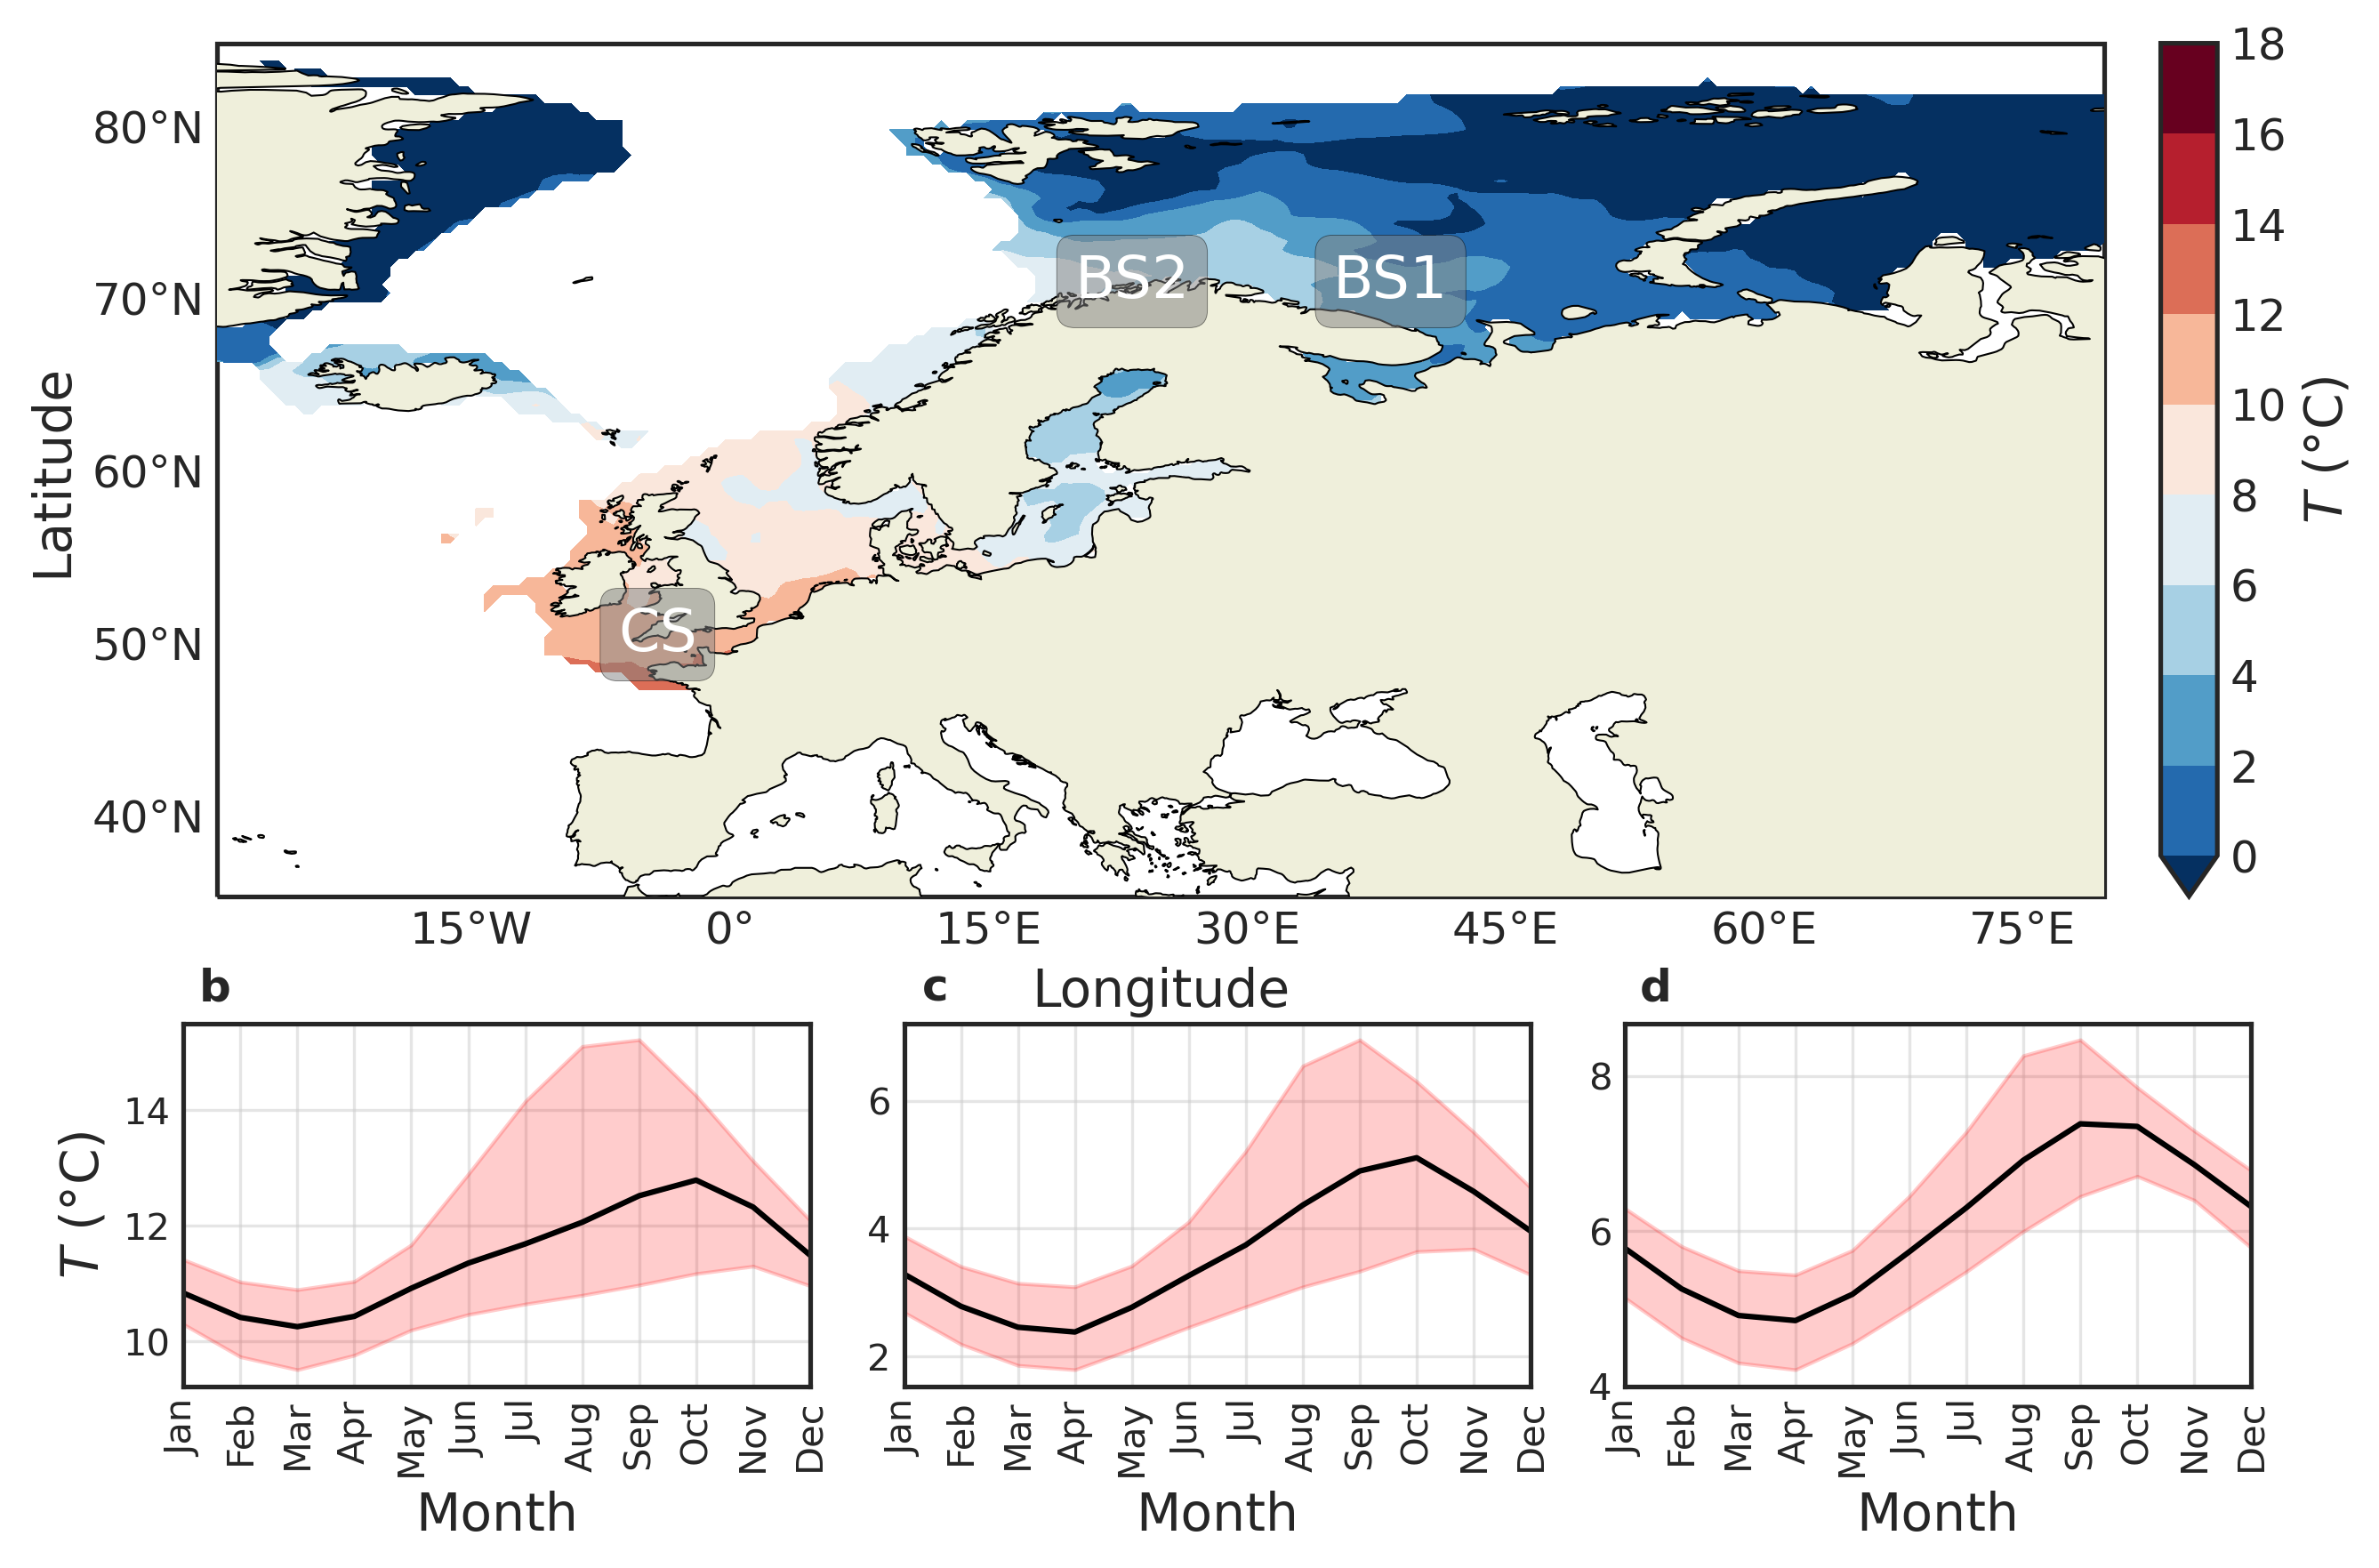

In [7]:
with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(10,10*(2/3)), dpi=300, tight_layout=True)
    gs = fig.add_gridspec(3, 3, wspace=.15, hspace=.35)

    # ____MAP_______
    ax1 = fig.add_subplot(gs[:2, :], projection=ccrs.PlateCarree())
    ax1.set_title('a', x=0.02, y=1.0, pad=6.0, weight='bold')
    xticks, yticks = np.arange(lon_na.start, lon_na.stop+1,15), np.arange(30,81,10)
    ax1.set_xticks(xticks)
    ax1.set_yticks(yticks)
    ax1.set_yticklabels(yticks, fontsize=12) 
    ax1.set_xticklabels(xticks, fontsize=12) 
    ax1.xaxis.set_major_formatter(cticker.LongitudeFormatter())
    ax1.yaxis.set_major_formatter(cticker.LatitudeFormatter())
    
    x1 = ds_fig1_spatial_map.where(ds_fig1_spatial_map.latitude<47)
    x2 = x1.where(ds_fig1_spatial_map.longitude>0)
    mappable = ds_fig1_spatial_map.where(
        ds_fig1_spatial_map != x1
    ).where(
        ds_fig1_spatial_map != x2
    ).plot.contourf(
        ax=ax1, levels=np.arange(0,20,2), add_colorbar=False, zorder=5
    )
    
    ax1.set_xlabel('Longitude', fontsize=14)
    ax1.set_ylabel('Latitude', fontsize=14)
    ax1.add_feature(
        cfeature.LAND, 
        zorder=5,  edgecolor='k', linewidth=0.5, 
        facecolor=cfeature.COLORS['land']
    )
    
    # ---- C O L O R - B A R ----
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', '3%', pad='3%', axes_class=mpl.pyplot.Axes)
    cbar = ax1.get_figure().colorbar(mappable, cax=cax, orientation='vertical')
    cbar.set_label('$T$ (°C)', fontsize=14)
    cbar.ax.tick_params(labelsize=12) 
    
    add_symbols(ax1)
        
    # ______CelticSea (Celtic Sea + English Channel)_______
    ax2 = fig.add_subplot(gs[-1, 0])
    ax2.set_title('b', x=0.05, y=1.0, pad=6.0, weight='bold')
    ax2.set_ylabel('$T$ (°C)', fontsize=14)
    
    ax2.plot(ds_fig1_cs_median, color='black')
    for q in [ ds_fig1_cs_q25, ds_fig1_cs_q75 ]:
        ax2.fill_between(
            np.arange(len(ds_fig1_cs_median)), ds_fig1_cs_median, q,
            alpha=.2, color='red'
        )
        
    # ______Barents Sea (area 1)_______
    ax3 = fig.add_subplot(gs[-1, 1])#, sharey=ax2)
    ax3.set_title('c', x=0.05, y=1.0, pad=6.0, weight='bold')
    
    ax3.plot(ds_fig1_bs1_median, color='black')
    for q in [ ds_fig1_bs1_q25, ds_fig1_bs1_q75 ]: 
        ax3.fill_between(
            np.arange(len(ds_fig1_bs1_median)), ds_fig1_bs1_median, q,
            alpha=.2, color='red'
        )    
    
    # ______Barents Sea (area 2)_______
    ax4 = fig.add_subplot(gs[-1, 2])#, sharey=ax2)
    ax4.set_title('d', x=0.05, y=1.0, pad=6.0, weight='bold')
    
    ax4.plot(ds_fig1_bs2_median, color='black')
    for q in [ ds_fig1_bs2_q25, ds_fig1_bs2_q75 ]: 
        ax4.fill_between(
            np.arange(len(ds_fig1_bs2_median)), ds_fig1_bs2_median, q,
            alpha=.2, color='red'
        )
    
    for ax in [ ax2, ax3, ax4 ]:
        ax.set_xticks(np.arange(12), fontsize=12)
        ax.set_xticklabels(str_months, rotation=90)
        ax.set_xlabel('Month', fontsize=14)
        ax.grid(True, alpha=.5)
        ax.set_xlim(0,11)
        #ax.set_ylim(0,16)
        #ax.set_yticks(np.arange(0,17,4), fontsize=12)
        #ax.annotate(i, xy=(10.5,2.5), fontsize=16, ha='right', va='top')

In [8]:
fesom_rcp45 = xr.open_mfdataset('../fesom_rcp45/*.nc')
rcp45_2080_2100_na = fesom_rcp45.sel(time=time_1, lat=lat_na, lon=lon_na, depth=depth)[var]
rcp45_2080_2100_cs = fesom_rcp45.sel(time=time_1, lat=lat_cs, lon=lon_cs, depth=depth)[var]
rcp45_2080_2100_bs1 = fesom_rcp45.sel(time=time_1, lat=lat_bs1, lon=lon_bs1, depth=depth)[var]
rcp45_2080_2100_bs2 = fesom_rcp45.sel(time=time_1, lat=lat_bs2, lon=lon_bs2, depth=depth)[var]

rcp45_2180_2200_na = fesom_rcp45.sel(time=time_2, lat=lat_na, lon=lon_na, depth=depth)[var]
rcp45_2180_2200_cs = fesom_rcp45.sel(time=time_2, lat=lat_cs, lon=lon_cs, depth=depth)[var]
rcp45_2180_2200_bs1 = fesom_rcp45.sel(time=time_2, lat=lat_bs1, lon=lon_bs1, depth=depth)[var]
rcp45_2180_2200_bs2 = fesom_rcp45.sel(time=time_2, lat=lat_bs2, lon=lon_bs2, depth=depth)[var]

fesom_rcp85 = xr.open_mfdataset('../fesom_rcp85/*.nc')
rcp85_2080_2100_na = fesom_rcp85.sel(time=time_1, lat=lat_na, lon=lon_na, depth=depth)[var]
rcp85_2080_2100_cs = fesom_rcp85.sel(time=time_1, lat=lat_cs, lon=lon_cs, depth=depth)[var]
rcp85_2080_2100_bs1 = fesom_rcp85.sel(time=time_1, lat=lat_bs1, lon=lon_bs1, depth=depth)[var]
rcp85_2080_2100_bs2 = fesom_rcp85.sel(time=time_1, lat=lat_bs2, lon=lon_bs2, depth=depth)[var]

rcp85_2180_2200_na = fesom_rcp85.sel(time=time_2, lat=lat_na, lon=lon_na, depth=depth)[var]
rcp85_2180_2200_cs = fesom_rcp85.sel(time=time_2, lat=lat_cs, lon=lon_cs, depth=depth)[var]
rcp85_2180_2200_bs1 = fesom_rcp85.sel(time=time_2, lat=lat_bs1, lon=lon_bs1, depth=depth)[var]
rcp85_2180_2200_bs2 = fesom_rcp85.sel(time=time_2, lat=lat_bs2, lon=lon_bs2, depth=depth)[var]

In [9]:
rcp45_2080_2100_spatial_na = rcp45_2080_2100_na.mean('depth').groupby('time.year').mean('time').mean('year').load()
rcp45_2080_2100_cs_median = rcp45_2080_2100_cs.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp45_2080_2100_bs1_median = rcp45_2080_2100_bs1.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp45_2080_2100_bs2_median = rcp45_2080_2100_bs2.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp45_2080_2100_cs_q25 = rcp45_2080_2100_cs.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2080_2100_bs1_q25 = rcp45_2080_2100_bs1.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2080_2100_bs2_q25 = rcp45_2080_2100_bs2.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2080_2100_cs_q75 = rcp45_2080_2100_cs.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2080_2100_bs1_q75 = rcp45_2080_2100_bs1.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2080_2100_bs2_q75 = rcp45_2080_2100_bs2.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()

rcp45_2180_2200_spatial_na = rcp45_2180_2200_na.mean('depth').groupby('time.year').mean('time').mean('year').load()
rcp45_2180_2200_cs_median = rcp45_2180_2200_cs.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp45_2180_2200_bs1_median = rcp45_2180_2200_bs1.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp45_2180_2200_bs2_median = rcp45_2180_2200_bs2.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp45_2180_2200_cs_q25 = rcp45_2180_2200_cs.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2180_2200_bs1_q25 = rcp45_2180_2200_bs1.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2180_2200_bs2_q25 = rcp45_2180_2200_bs2.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2180_2200_cs_q75 = rcp45_2180_2200_cs.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2180_2200_bs1_q75 = rcp45_2180_2200_bs1.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp45_2180_2200_bs2_q75 = rcp45_2180_2200_bs2.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()

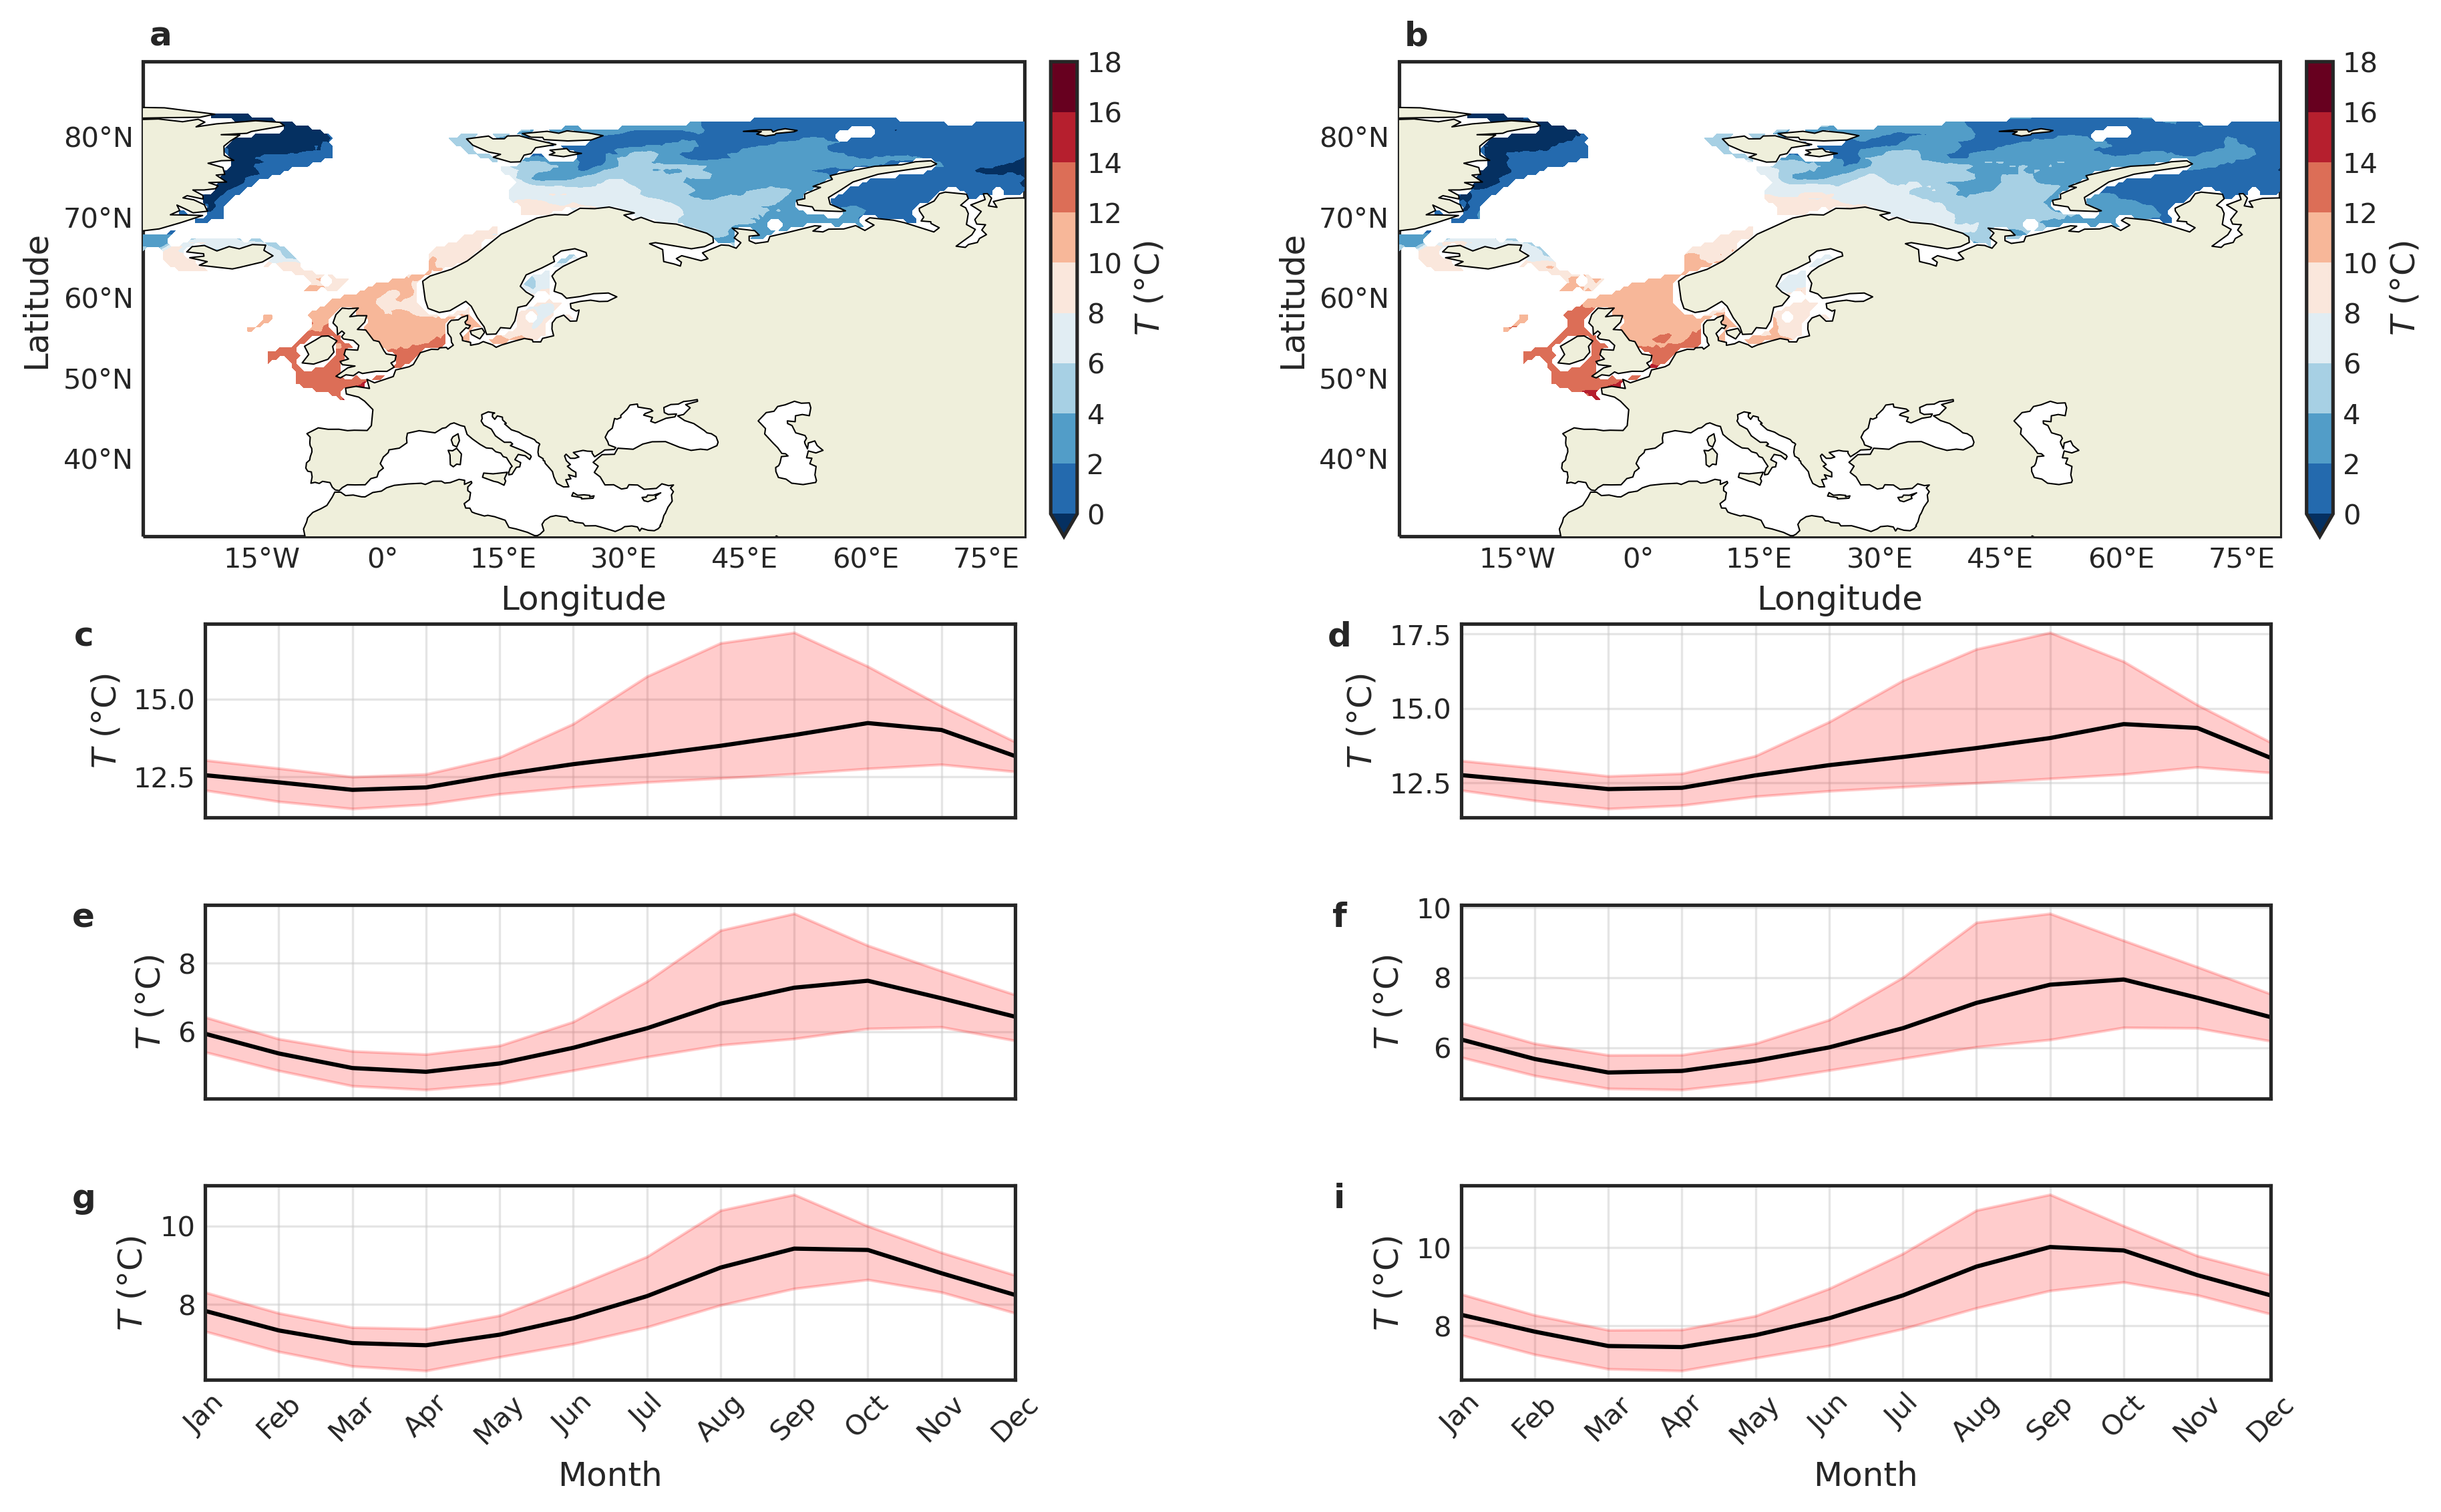

In [18]:
with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(16,18),dpi=300, tight_layout=True)
    
    #gs = fig.add_gridspec(10, 12, wspace=100)
    gs = fig.add_gridspec(10, 12, wspace=.15, hspace=.45)

    
    width = 6
    height_a = 2
    height_b = 1
    
    space_between_map_and_line_plot = 0
    map_labels = ['a', 'b']
    labels = [
        ['c', 'd'],
        ['e', 'f'],
        ['g', 'i']
    ]
    for i, ds in enumerate([rcp45_2080_2100_spatial_na, rcp45_2180_2200_spatial_na]):
        
        # ____MAP_1_______
        ax_m = fig.add_subplot(gs[0:height_a,i*width:i*width+width], projection=ccrs.PlateCarree())
        
        
        xticks, yticks = np.arange(lon_na.start, lon_na.stop+1,15), np.arange(30,81,10)
        ax_m.set_xticks(xticks)
        ax_m.set_yticks(yticks)
        ax_m.set_yticklabels(yticks, fontsize=10) 
        ax_m.set_xticklabels(xticks, fontsize=10) 
        ax_m.xaxis.set_major_formatter(cticker.LongitudeFormatter())
        ax_m.yaxis.set_major_formatter(cticker.LatitudeFormatter())

        x1 = ds.where(ds.lat<47)
        x2 = x1.where(ds.lon>0)
        mappable = ds.where(ds != x1).where(ds != x2).plot.contourf(
            ax=ax_m, levels=np.arange(0,20,2), add_colorbar=False, zorder=5,
            cmap='RdBu_r'
        )    
        ax_m.set_xlabel('Longitude', fontsize=12)
        ax_m.set_ylabel('Latitude', fontsize=12)
        ax_m.set_title(map_labels[i], x=.02, y=1, pad=6.0, weight='bold')
        ax_m.add_feature(
            cfeature.LAND, 
            zorder=5,  edgecolor='k', linewidth=0.5, 
            facecolor=cfeature.COLORS['land']
        )

        divider = make_axes_locatable(ax_m)
        cax = divider.append_axes('right', '3%', pad='3%', axes_class=mpl.pyplot.Axes)
        cbar = ax_m.get_figure().colorbar(mappable, cax=cax, orientation='vertical')
        cbar.set_label('$T$ (°C)', fontsize=12)
        cbar.ax.tick_params(labelsize=10) 
        
        #add_symbols(ax_m)
        
    for i, (row, ds_2080_2100, ds_2180_2200) in enumerate(zip(
        [
            height_a+space_between_map_and_line_plot, 
            height_a+height_b+space_between_map_and_line_plot, 
            height_a+2*height_b+space_between_map_and_line_plot], 
        [ # left column
            [rcp45_2080_2100_cs_median, rcp45_2080_2100_cs_q25, rcp45_2080_2100_cs_q75], 
            [rcp45_2080_2100_bs1_median, rcp45_2080_2100_bs1_q25, rcp45_2080_2100_bs1_q75],
            [rcp45_2080_2100_bs2_median, rcp45_2080_2100_bs2_q25, rcp45_2080_2100_bs2_q75]
        ],[ # right column
            [rcp45_2180_2200_cs_median, rcp45_2180_2200_cs_q25, rcp45_2180_2200_cs_q75], 
            [rcp45_2180_2200_bs1_median, rcp45_2180_2200_bs1_q25, rcp45_2180_2200_bs1_q75],
            [rcp45_2180_2200_bs2_median, rcp45_2180_2200_bs2_q25, rcp45_2180_2200_bs2_q75]
        ]
    )):
        
        ax_l = fig.add_subplot(gs[row:row+height_b,0+1:width-1])
        ax_l.set_title(labels[i][0], x=-.15, y=.8, pad=6.0, weight='bold')
        #ax_l.set_ylabel('$T$ (°C)', fontsize=12)
        
        ax_l.plot(ds_2080_2100[0], color='black')
        for q in [ ds_2080_2100[1], ds_2080_2100[2] ]:
            ax_l.fill_between(
                np.arange(len(ds_2080_2100[0])), ds_2080_2100[0], q,
                alpha=.2, color='red'
            )
            
        ax_r = fig.add_subplot(gs[row:row+height_b,width+1:2*width-1])
        ax_r.set_title(labels[i][1], x=-.15, y=.8, pad=6.0, weight='bold')

        ax_r.plot(ds_2180_2200[0], color='black')
        for q in [ ds_2180_2200[1], ds_2180_2200[2] ]:
            ax_r.fill_between(
                np.arange(len(ds_2180_2200[0])), ds_2180_2200[0], q,
                alpha=.2, color='red'
            )
        
        for ax in [ ax_l, ax_r ]:
            ax.grid(True, alpha=.5)
            ax.set_xlim(0,11)
            ax.set_xticks(np.arange(12))            
            ax.set_xticklabels(['' for tick in ax.get_xticks()])  
            ax.set_ylabel('$T$ (°C)', fontsize=12)
            
            if row == height_a+2*height_b+space_between_map_and_line_plot:
                ax.set_xticks(np.arange(12))
                ax.set_xticklabels(str_months, rotation=45)
                ax.set_xlabel('Month', fontsize=12)
                
            
    #plt.savefig('rcp45_l-2080-2100_r-2180-2200.png', bbox_inches='tight')

In [15]:
rcp85_2080_2100_spatial_na = rcp85_2080_2100_na.mean('depth').groupby('time.year').mean('time').mean('year').load()
rcp85_2080_2100_cs_median = rcp85_2080_2100_cs.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp85_2080_2100_bs1_median = rcp85_2080_2100_bs1.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp85_2080_2100_bs2_median = rcp85_2080_2100_bs2.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp85_2080_2100_cs_q25 = rcp85_2080_2100_cs.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2080_2100_bs1_q25 = rcp85_2080_2100_bs1.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2080_2100_bs2_q25 = rcp85_2080_2100_bs2.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2080_2100_cs_q75 = rcp85_2080_2100_cs.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2080_2100_bs1_q75 = rcp85_2080_2100_bs1.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2080_2100_bs2_q75 = rcp85_2080_2100_bs2.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()

rcp85_2180_2200_spatial_na = rcp85_2180_2200_na.mean('depth').groupby('time.year').mean('time').mean('year').load()
rcp85_2180_2200_cs_median = rcp85_2180_2200_cs.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp85_2180_2200_bs1_median = rcp85_2180_2200_bs1.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp85_2180_2200_bs2_median = rcp85_2180_2200_bs2.median(['depth', 'lon', 'lat']).groupby('time.month').mean().load()
rcp85_2180_2200_cs_q25 = rcp85_2180_2200_cs.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2180_2200_bs1_q25 = rcp85_2180_2200_bs1.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2180_2200_bs2_q25 = rcp85_2180_2200_bs2.quantile(.25, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2180_2200_cs_q75 = rcp85_2180_2200_cs.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2180_2200_bs1_q75 = rcp85_2180_2200_bs1.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()
rcp85_2180_2200_bs2_q75 = rcp85_2180_2200_bs2.quantile(.75, ['depth', 'lat', 'lon']).groupby('time.month').mean().load()

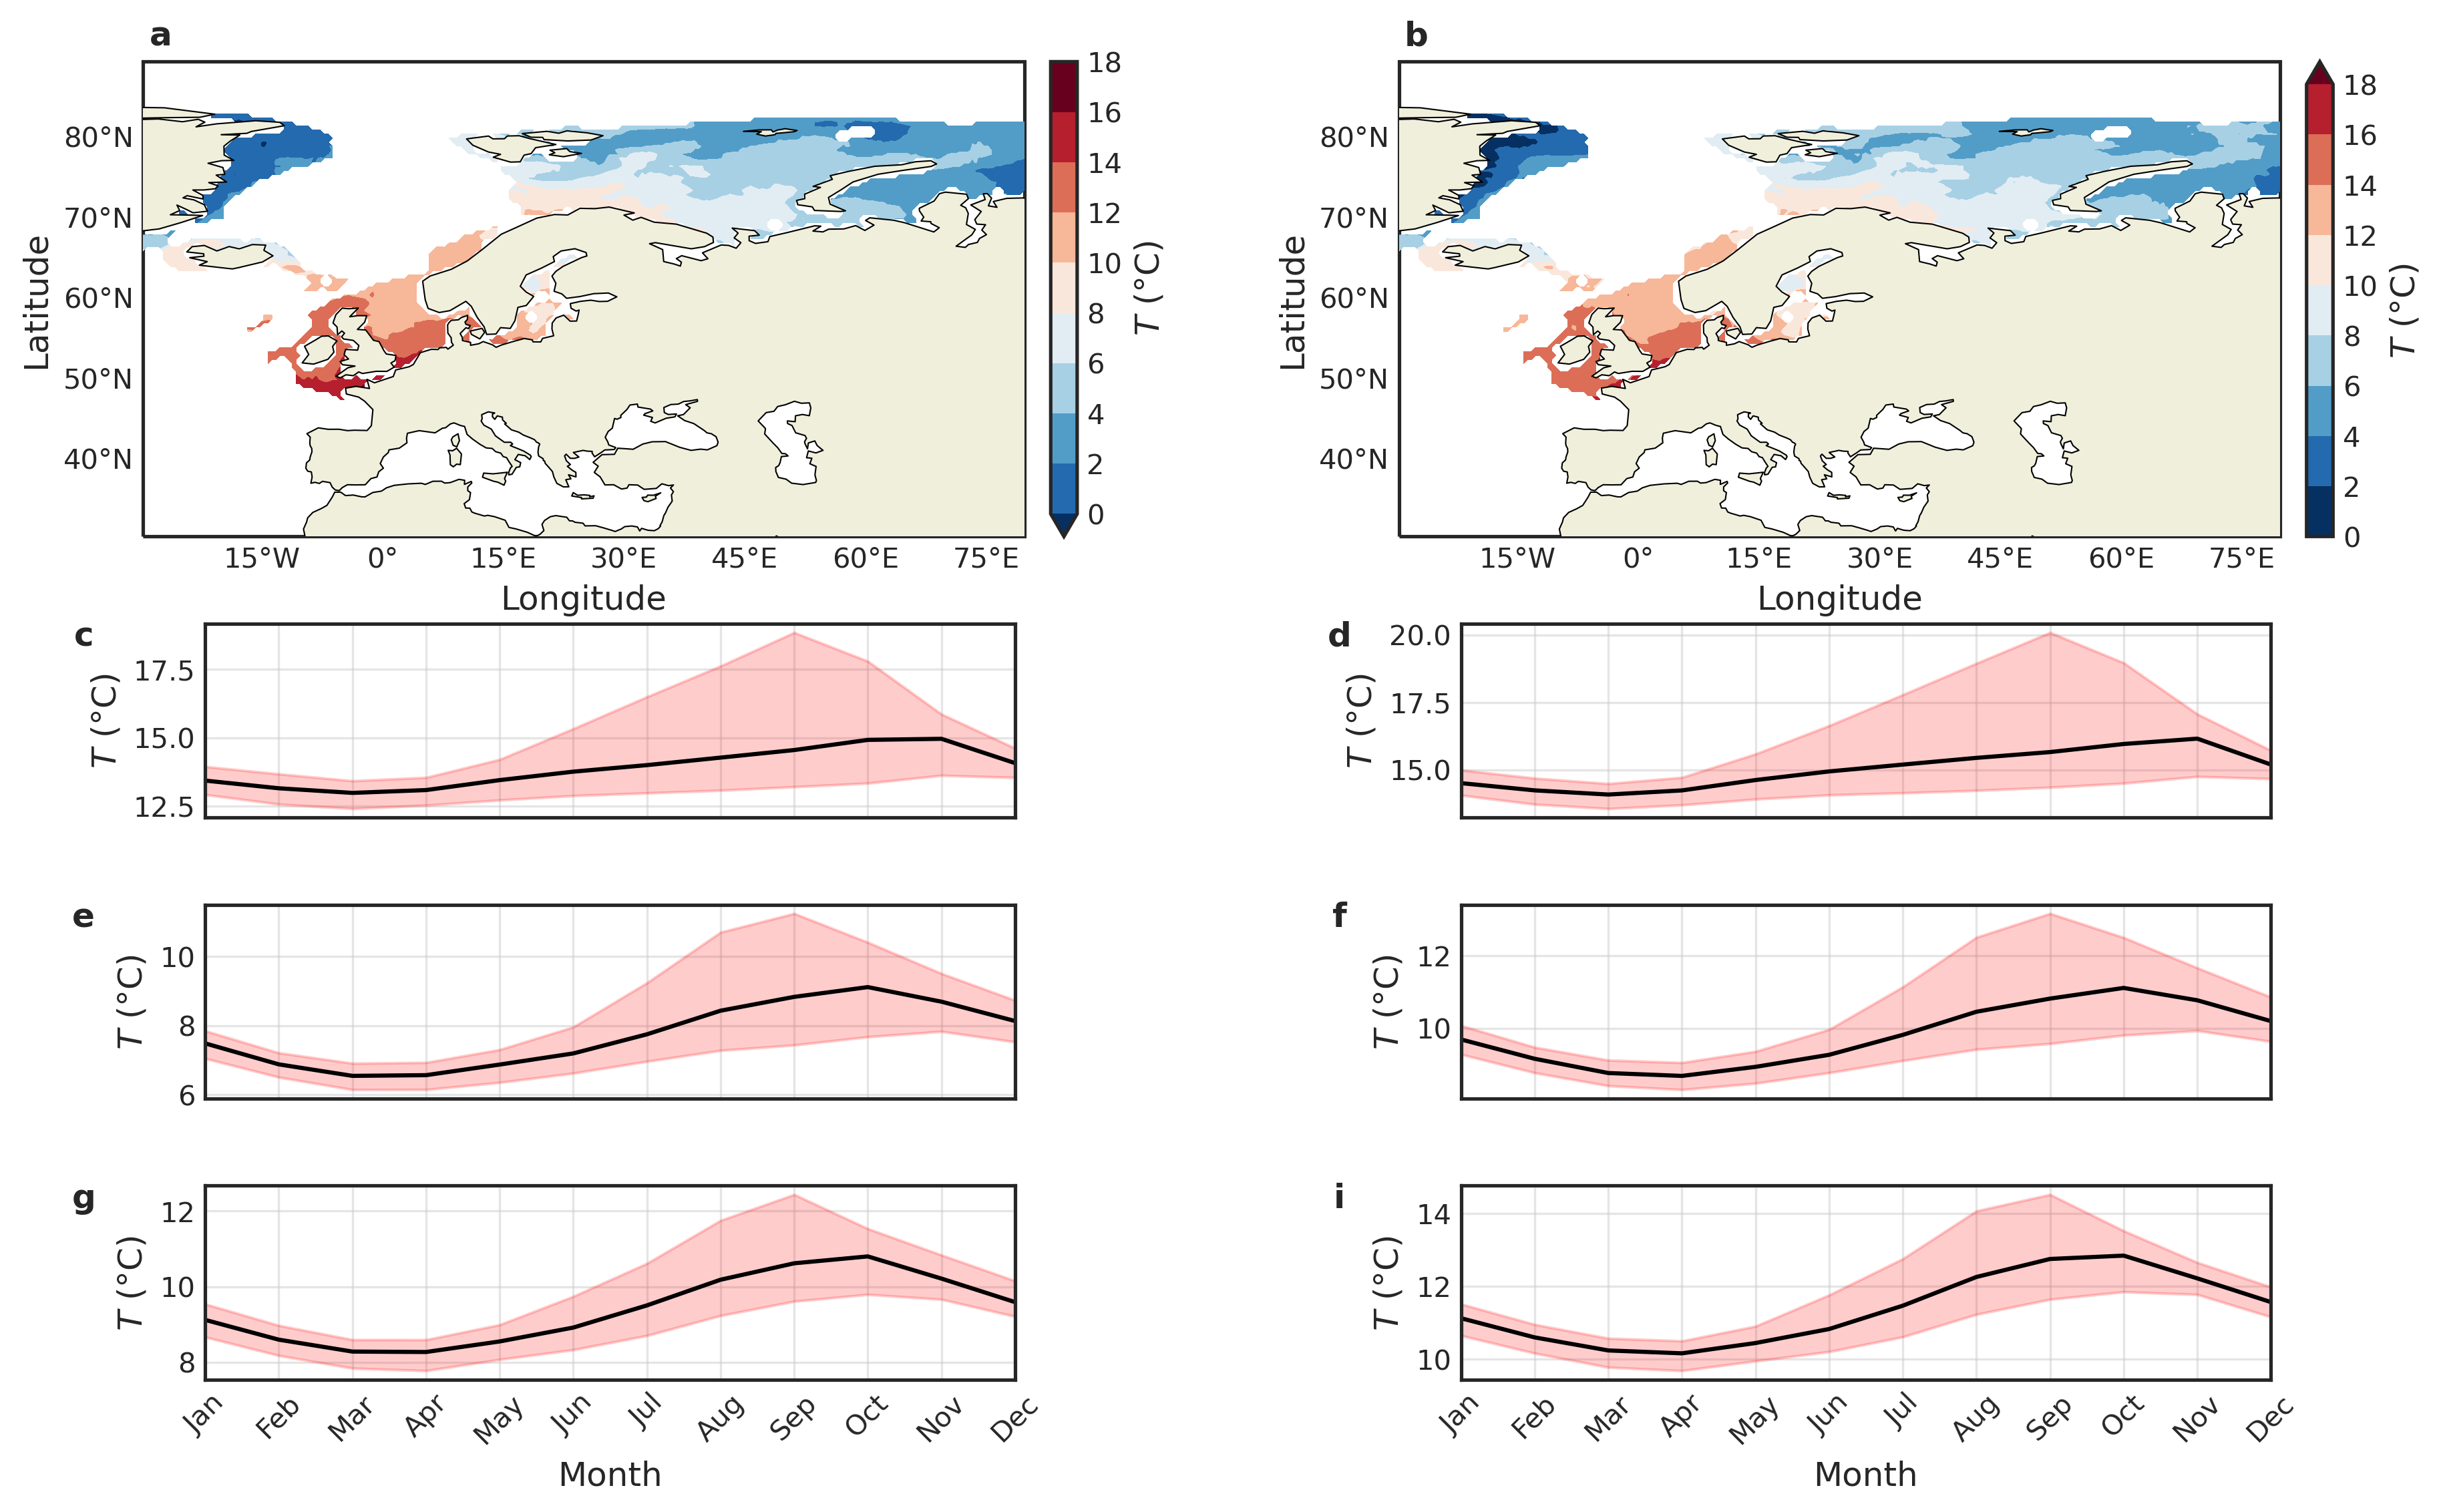

In [19]:
with plt.style.context('seaborn-white'):
    fig = plt.figure(figsize=(16,18),dpi=300)
    gs = fig.add_gridspec(10, 12, wspace=.15, hspace=.45)

    #gs = fig.add_gridspec(10, 12, wspace=100)
    
    width = 6
    height_a = 2
    height_b = 1
    
    space_between_map_and_line_plot = 0
    map_labels = ['a', 'b']
    labels = [
        ['c', 'd'],
        ['e', 'f'],
        ['g', 'i']
    ]
    for i, ds in enumerate([rcp85_2080_2100_spatial_na, rcp85_2180_2200_spatial_na]):
        
        # ____MAP_1_______
        ax_m = fig.add_subplot(gs[0:height_a,i*width:i*width+width], projection=ccrs.PlateCarree())      
        xticks, yticks = np.arange(lon_na.start, lon_na.stop+1,15), np.arange(30,81,10)
        ax_m.set_xticks(xticks)
        ax_m.set_yticks(yticks)
        ax_m.set_yticklabels(yticks, fontsize=10) 
        ax_m.set_xticklabels(xticks, fontsize=10) 
        ax_m.xaxis.set_major_formatter(cticker.LongitudeFormatter())
        ax_m.yaxis.set_major_formatter(cticker.LatitudeFormatter())

        x1 = ds.where(ds.lat<47)
        x2 = x1.where(ds.lon>0)
        mappable = ds.where(ds != x1).where(ds != x2).plot.contourf(
            ax=ax_m, levels=np.arange(0,20,2), add_colorbar=False, zorder=5,
            cmap='RdBu_r'
        )    
        ax_m.set_xlabel('Longitude', fontsize=12)
        ax_m.set_ylabel('Latitude', fontsize=12)
        ax_m.set_title(map_labels[i], x=.02, y=1, pad=6.0, weight='bold')
        ax_m.add_feature(
            cfeature.LAND, 
            zorder=5, edgecolor='k', linewidth=0.5, 
            facecolor=cfeature.COLORS['land']
        )

        divider = make_axes_locatable(ax_m)
        cax = divider.append_axes('right', '3%', pad='3%', axes_class=mpl.pyplot.Axes)
        cbar = ax_m.get_figure().colorbar(mappable, cax=cax, orientation='vertical')
        cbar.set_label('$T$ (°C)', fontsize=12)
        cbar.ax.tick_params(labelsize=10) 
        #add_symbols(ax_m)
        
    for i, (row, ds_2080_2100, ds_2180_2200) in enumerate(zip(
        [
            height_a+space_between_map_and_line_plot, 
            height_a+height_b+space_between_map_and_line_plot, 
            height_a+2*height_b+space_between_map_and_line_plot], 
        [ # left column
            [rcp85_2080_2100_cs_median, rcp85_2080_2100_cs_q25, rcp85_2080_2100_cs_q75], 
            [rcp85_2080_2100_bs1_median, rcp85_2080_2100_bs1_q25, rcp85_2080_2100_bs1_q75],
            [rcp85_2080_2100_bs2_median, rcp85_2080_2100_bs2_q25, rcp85_2080_2100_bs2_q75]
        ],[ # right column
            [rcp85_2180_2200_cs_median, rcp85_2180_2200_cs_q25, rcp85_2180_2200_cs_q75], 
            [rcp85_2180_2200_bs1_median, rcp85_2180_2200_bs1_q25, rcp85_2180_2200_bs1_q75],
            [rcp85_2180_2200_bs2_median, rcp85_2180_2200_bs2_q25, rcp85_2180_2200_bs2_q75]
        ]
    )):
        
        ax_l = fig.add_subplot(gs[row:row+height_b,0+1:width-1])
        ax_l.set_title(labels[i][0], x=-.15, y=.8, pad=6.0, weight='bold')
        
        ax_l.plot(ds_2080_2100[0], color='black')
        for q in [ ds_2080_2100[1], ds_2080_2100[2] ]:
            ax_l.fill_between(
                np.arange(len(ds_2080_2100[0])), ds_2080_2100[0], q,
                alpha=.2, color='red'
            )
            
        ax_r = fig.add_subplot(gs[row:row+height_b,width+1:2*width-1])
        ax_r.set_title(labels[i][1], x=-.15, y=.8, pad=6.0, weight='bold')

        ax_r.plot(ds_2180_2200[0], color='black')
        for q in [ ds_2180_2200[1], ds_2180_2200[2] ]:
            ax_r.fill_between(
                np.arange(len(ds_2180_2200[0])), ds_2180_2200[0], q,
                alpha=.2, color='red'
            )
        
        for ax in [ ax_l, ax_r ]:
            ax.grid(True, alpha=.5)
            ax.set_xlim(0,11)
            ax.set_xticks(np.arange(12))            
            ax.set_xticklabels(['' for tick in ax.get_xticks()])  
            ax.set_ylabel('$T$ (°C)', fontsize=12)
            
            if row == height_a+2*height_b+space_between_map_and_line_plot:
                ax.set_xticks(np.arange(12))
                ax.set_xticklabels(str_months, rotation=45)
                ax.set_xlabel('Month', fontsize=12)
                
            
#plt.savefig('rcp45_l-2080-2100_r-2180-2200.png', bbox_inches='tight')

_____
Fig. 2. Projected seasonal cycles (2080-2100 and 2180-2200, if possible both periods in one subplot, so in total 3 subplots)  
Regions are the same as for SODA.
+ seasonal data saved as csv

In [13]:
fesom_rcp45 = xr.open_mfdataset('/Users/benjamin/repositories/awi-workspace/growth_model_atlantic_cod_inputs/fesom_rcp45/*.nc') 
fesom_rcp45_2080_2100_na_seas = fesom_rcp45.sel(time=time_1, lat=lat_na, lon=lon_na, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2080_2100_cs_seas = fesom_rcp45.sel(time=time_1, lat=lat_cs, lon=lon_cs, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2080_2100_bs1_seas = fesom_rcp45.sel(time=time_1, lat=lat_bs1, lon=lon_bs1, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2080_2100_bs2_seas = fesom_rcp45.sel(time=time_1, lat=lat_bs2, lon=lon_bs2, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2180_2200_na_seas = fesom_rcp45.sel(time=time_2, lat=lat_na, lon=lon_na, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2180_2200_cs_seas = fesom_rcp45.sel(time=time_2, lat=lat_cs, lon=lon_cs, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2180_2200_bs1_seas = fesom_rcp45.sel(time=time_2, lat=lat_bs1, lon=lon_bs1, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp45_2180_2200_bs2_seas = fesom_rcp45.sel(time=time_2, lat=lat_bs2, lon=lon_bs2, depth=depth)[var].groupby('time.month').mean(...)

fesom_rcp85 = xr.open_mfdataset('/Users/benjamin/repositories/awi-workspace/growth_model_atlantic_cod_inputs/fesom_rcp85/*.nc') 
fesom_rcp85_2080_2100_na_seas = fesom_rcp85.sel(time=time_1, lat=lat_na, lon=lon_na, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2080_2100_cs_seas = fesom_rcp85.sel(time=time_1, lat=lat_cs, lon=lon_cs, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2080_2100_bs1_seas = fesom_rcp85.sel(time=time_1, lat=lat_bs1, lon=lon_bs1, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2080_2100_bs2_seas = fesom_rcp85.sel(time=time_1, lat=lat_bs2, lon=lon_bs2, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2180_2200_na_seas = fesom_rcp85.sel(time=time_2, lat=lat_na, lon=lon_na, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2180_2200_cs_seas = fesom_rcp85.sel(time=time_2, lat=lat_cs, lon=lon_cs, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2180_2200_bs1_seas = fesom_rcp85.sel(time=time_2, lat=lat_bs1, lon=lon_bs1, depth=depth)[var].groupby('time.month').mean(...)
fesom_rcp85_2180_2200_bs2_seas = fesom_rcp85.sel(time=time_2, lat=lat_bs2, lon=lon_bs2, depth=depth)[var].groupby('time.month').mean(...)

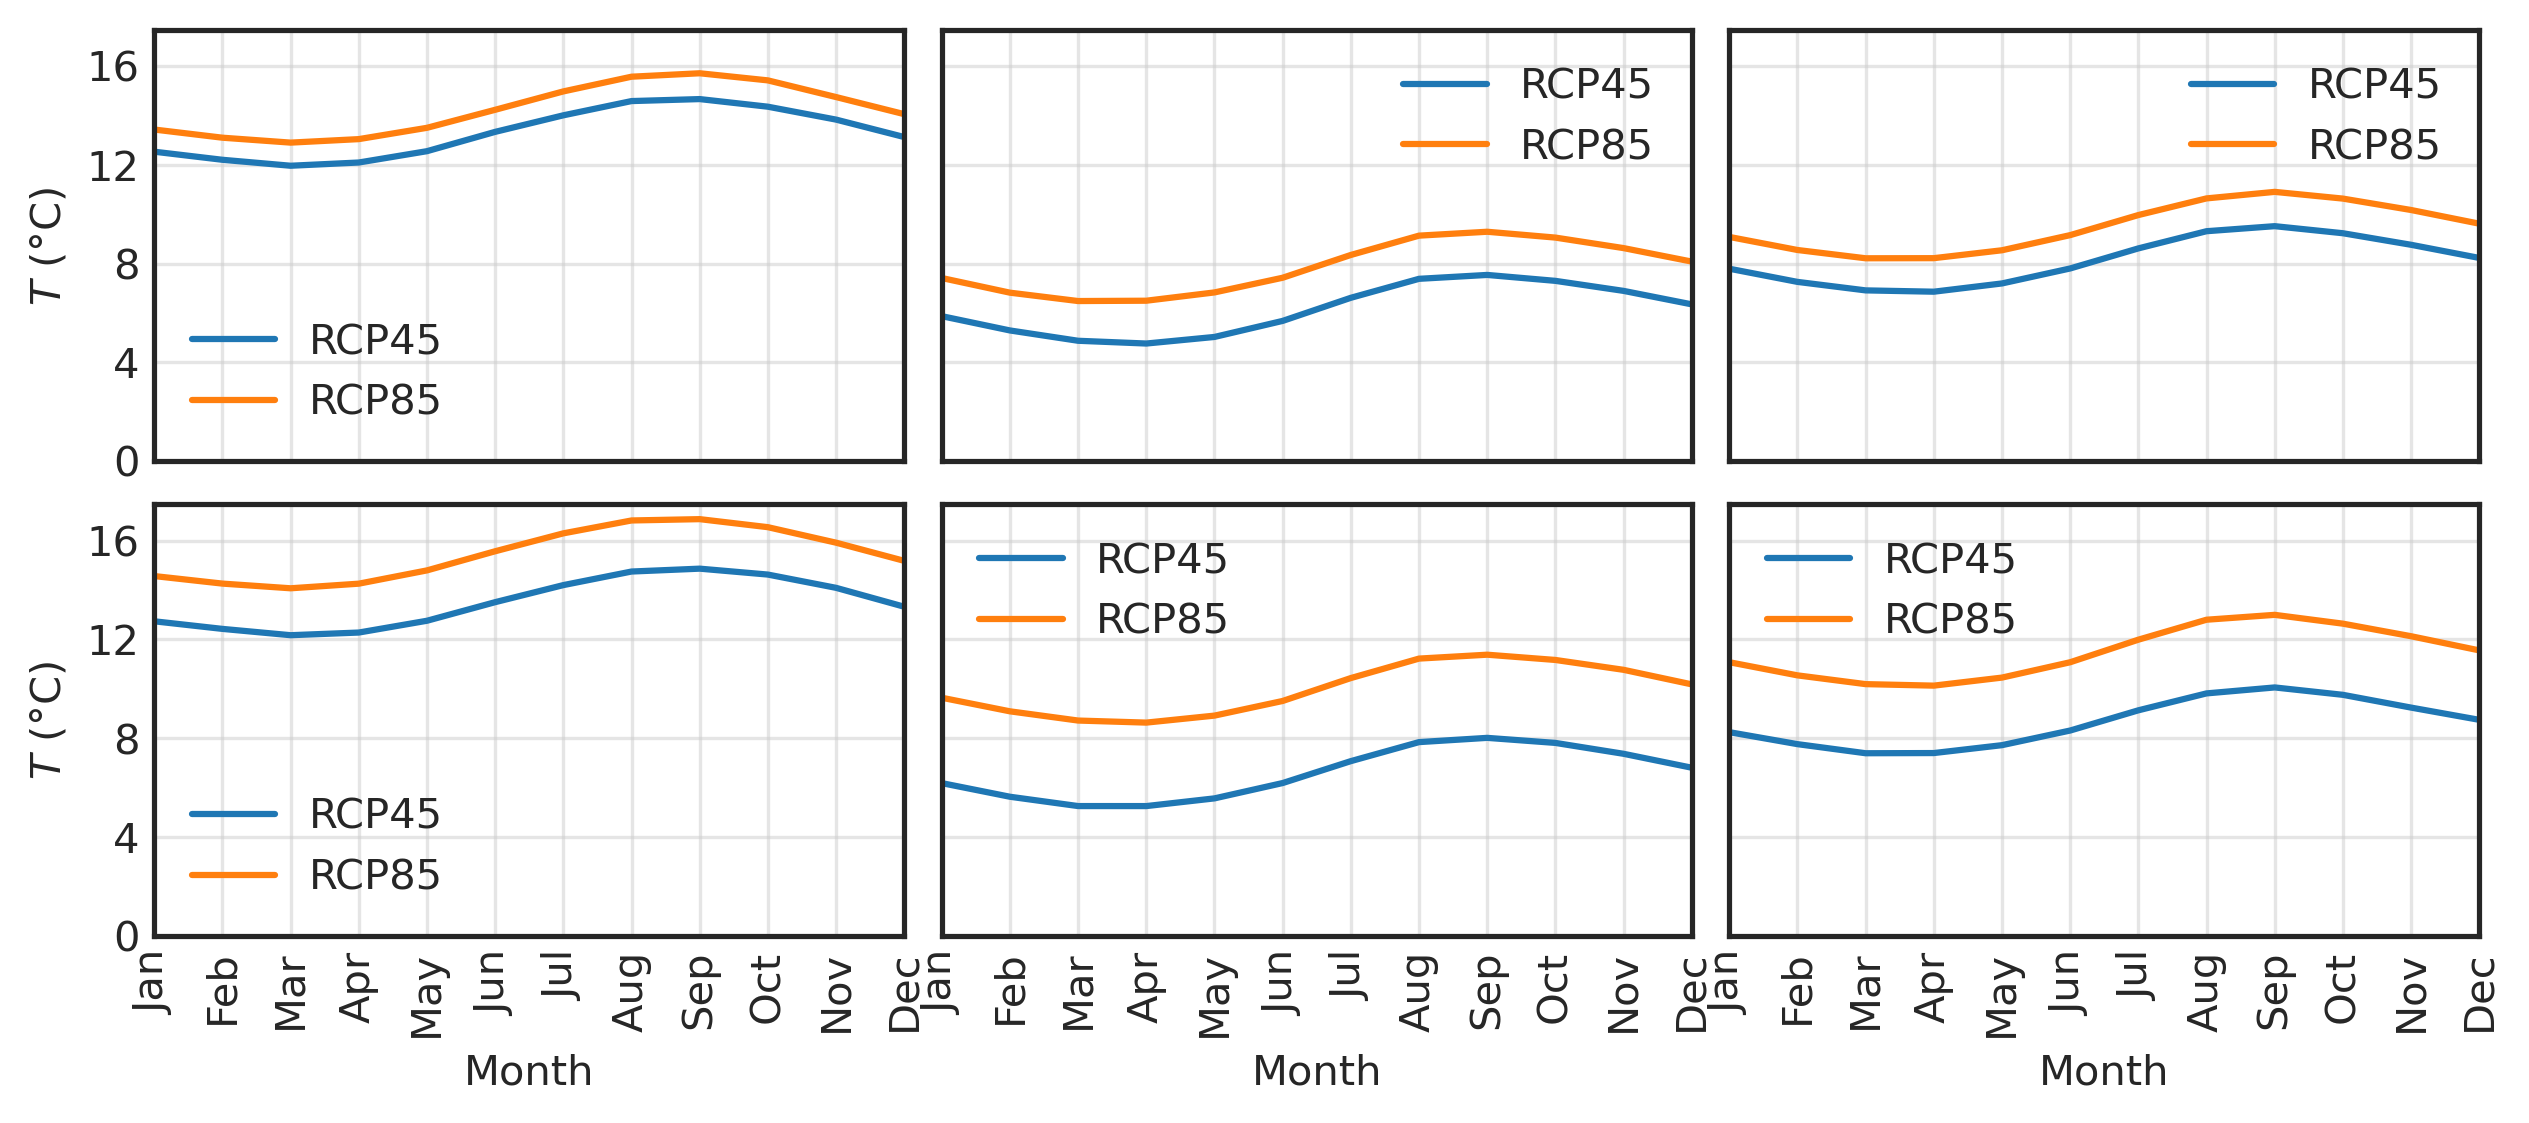

In [14]:
with plt.style.context('seaborn-white'):
    fig, axs = plt.subplots(
        figsize=(10,4), dpi=300, 
        nrows=2, ncols=3, constrained_layout=True, 
        sharey=True, sharex=True
    )
    fesom_rcp45_2080_2100_cs_seas.plot(ax=axs[0,0], label='RCP45')
    fesom_rcp85_2080_2100_cs_seas.plot(ax=axs[0,0], label='RCP85')

    fesom_rcp45_2080_2100_bs1_seas.plot(ax=axs[0,1], label='RCP45')
    fesom_rcp85_2080_2100_bs1_seas.plot(ax=axs[0,1], label='RCP85')

    fesom_rcp45_2080_2100_bs2_seas.plot(ax=axs[0,2], label='RCP45')
    fesom_rcp85_2080_2100_bs2_seas.plot(ax=axs[0,2], label='RCP85')


    fesom_rcp45_2180_2200_cs_seas.plot(ax=axs[1,0], label='RCP45')
    fesom_rcp85_2180_2200_cs_seas.plot(ax=axs[1,0], label='RCP85')

    fesom_rcp45_2180_2200_bs1_seas.plot(ax=axs[1,1], label='RCP45')
    fesom_rcp85_2180_2200_bs1_seas.plot(ax=axs[1,1], label='RCP85')

    fesom_rcp45_2180_2200_bs2_seas.plot(ax=axs[1,2], label='RCP45')
    fesom_rcp85_2180_2200_bs2_seas.plot(ax=axs[1,2], label='RCP85')
    plt.subplots_adjust(hspace=.1)
    plt.subplots_adjust(wspace=.05)

    for i, ax in enumerate(axs.flatten()):
        if i == 0 or i == 3: ax.set_ylabel('$T$ (°C)')
        else: ax.set_ylabel('')
        if i < 3: 
            ax.set_xlabel('')
            ax.set_xticklabels([])

    for ax in axs.flatten():     
        ax.legend()
        ax.set_xlim(1,12)
        ax.set_yticks(np.arange(0,17,4))
        ax.grid(True, alpha=.5)

    xticks = np.arange(1,13)
    for ax in axs.flatten()[-3:]:
        ax.set_xticks(xticks)
        ax.set_xticklabels(str_months, rotation=90)
        ax.set_xlabel('Month')

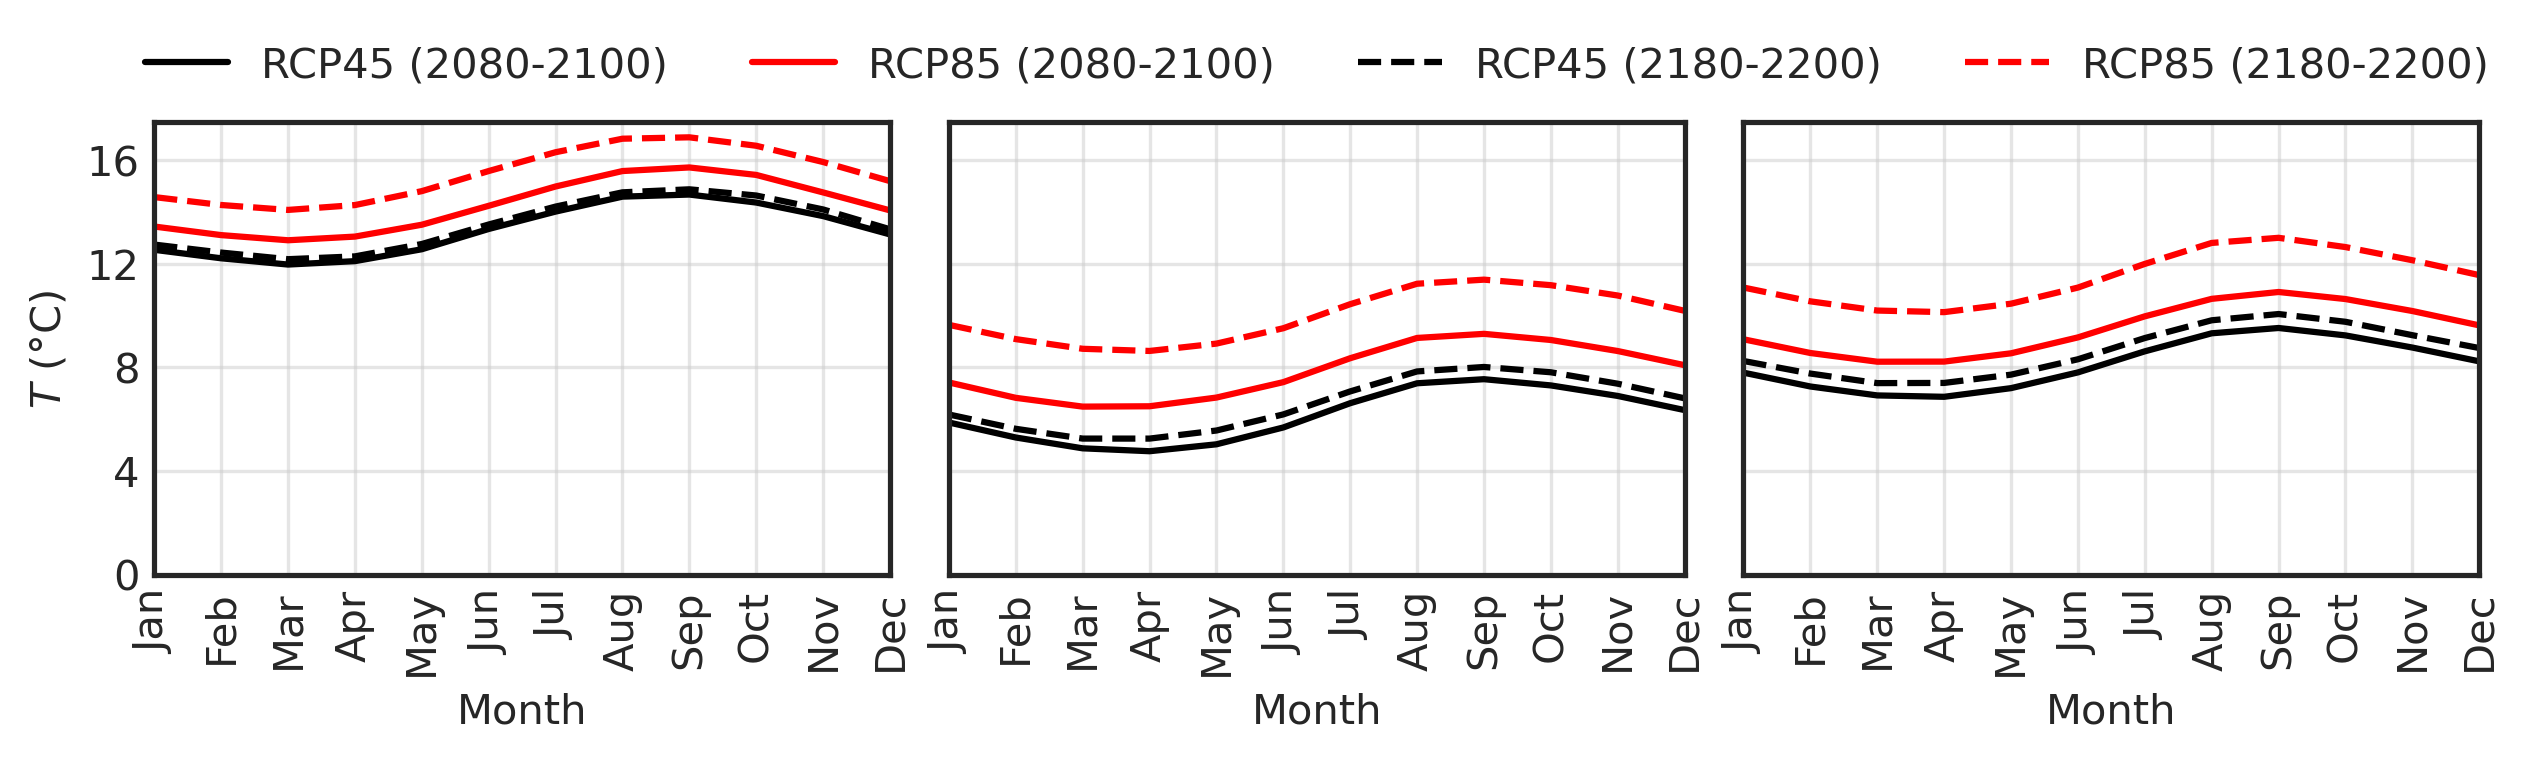

In [15]:
with plt.style.context('seaborn-white'):
    fig, axs = plt.subplots(
        figsize=(10,2), dpi=300, 
        nrows=1, ncols=3, constrained_layout=True, 
        sharey=True, sharex=True
    )
    cb, cr = 'black', 'red'
    a, b = 'RCP45', 'RCP85'

    fesom_rcp45_2080_2100_cs_seas.plot(ax=axs[0], label=f'{a}', color=cb)
    fesom_rcp85_2080_2100_cs_seas.plot(ax=axs[0], label=f'{b}', color=cr)
    fesom_rcp45_2180_2200_cs_seas.plot(ax=axs[0], label=f'{a}', color=cb, linestyle='--')
    fesom_rcp85_2180_2200_cs_seas.plot(ax=axs[0], label=f'{b}', color=cr, linestyle='--')

    fesom_rcp45_2080_2100_bs1_seas.plot(ax=axs[1], label=f'{a} (2080-2100)', color=cb)
    fesom_rcp85_2080_2100_bs1_seas.plot(ax=axs[1], label=f'{b} (2080-2100)', color=cr)
    fesom_rcp45_2180_2200_bs1_seas.plot(ax=axs[1], label=f'{a} (2180-2200)', color=cb, linestyle='--')
    fesom_rcp85_2180_2200_bs1_seas.plot(ax=axs[1], label=f'{b} (2180-2200)', color=cr, linestyle='--')

    fesom_rcp45_2080_2100_bs2_seas.plot(ax=axs[2], label=f'{a} (2080-2100)', color=cb)
    fesom_rcp85_2080_2100_bs2_seas.plot(ax=axs[2], label=f'{b} (2080-2100)', color=cr)
    fesom_rcp45_2180_2200_bs2_seas.plot(ax=axs[2], label=f'{a} (2180-2200)', color=cb, linestyle='--')
    fesom_rcp85_2180_2200_bs2_seas.plot(ax=axs[2], label=f'{b} (2180-2200)', color=cr, linestyle='--')

    plt.subplots_adjust(hspace=.1)
    plt.subplots_adjust(wspace=.08)

    xticks = np.arange(1,13)
    for ax in axs:
        ax.set_xticks(xticks)
        ax.set_xticklabels(str_months, rotation=90)
        ax.set_xlabel('Month')

        ax.set_xlim(1,12)
        ax.set_yticks(np.arange(0,17,4))
        ax.grid(True, alpha=.5)

    axs[1].legend(ncol=4, loc='upper center', bbox_to_anchor=(.5, 1.25))

    axs[0].set_ylabel('$T$ (°C)')
    [ax.set_ylabel('') for ax in axs[1:]]